In [94]:
import numpy as np
import argparse
import torch
import cv2 as cv

from natsort import natsorted

import os
import os.path as p

from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F

import pandas as pd

import utils
import seg.train_seg as seg
import data.datasets as data
import stn.stn_dataset as stn_dataset
import stn.train_stn as stn
import fine_tune

whole_dataset = data.get_whole_dataset('lesion', 'dermquest', stn_transformed=False)


In [95]:
unet = 'predictions/isic_baseline/dermquest'
stnunet = 'predictions/isic_stnunet/dermquest'

preds_unet = [cv.imread(p.join(unet, f), cv.IMREAD_GRAYSCALE) for f in natsorted(os.listdir(unet))]
preds_stnunet = [cv.imread(p.join(stnunet, f), cv.IMREAD_GRAYSCALE) for f in natsorted(os.listdir(stnunet))]

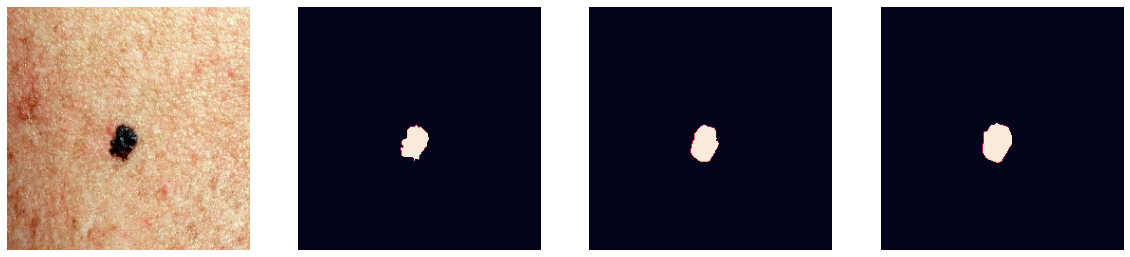

In [96]:
for i, (x, y) in enumerate(whole_dataset):
  if i < 70:
    continue
  x = x.squeeze().numpy().transpose(1, 2, 0) + 0.5
  y = y.squeeze().numpy()
  utils.show_images_row([x, y, preds_unet[i], preds_stnunet[i]], figsize=(20, 5))
  break

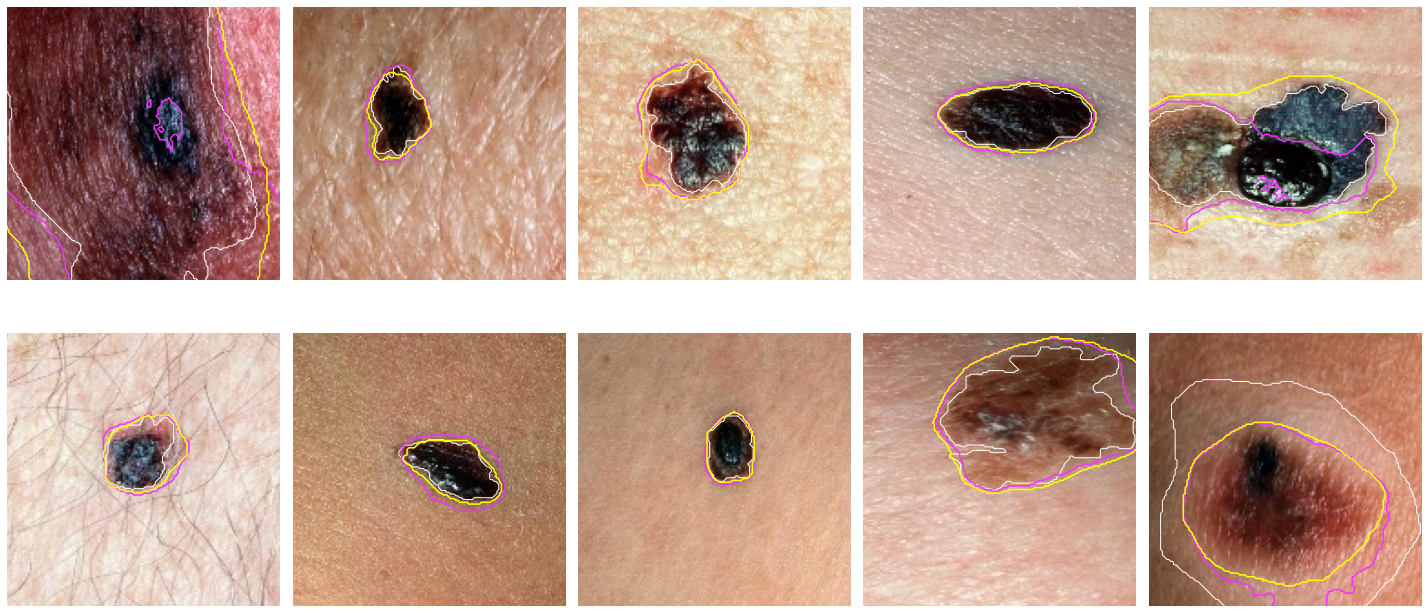

In [97]:
import matplotlib.pyplot as plt
from skimage import measure

indices = range(63,93,3)
fig, axs = plt.subplots(2, len(indices) // 2, figsize=(20, 10))
axs = axs.flatten()

for idx, ax in zip(indices, axs):
    ax.axis('off')
    x = whole_dataset[idx][0].squeeze().numpy().transpose(1, 2, 0) + 0.5
    y = whole_dataset[idx][1].squeeze().numpy()
    y_unet = preds_unet[idx]
    y_stnunet = preds_stnunet[idx]

    y_contours = measure.find_contours(y, 0.5)
    unet_contours = measure.find_contours(y_unet, 0.5)
    stnunet_contours = measure.find_contours(y_stnunet, 0.5)

    ax.imshow(x)

    for contour in y_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='white')

    for contour in unet_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='#F433FF')

    for contour in stnunet_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='yellow')

    ax.axis([50, 200, 50, 200])

plt.tight_layout()
plt.savefig('plots/output.png', bbox_inches='tight')

In [98]:
import pandas as pd
import os
from scipy.stats import ranksums
import scipy.stats as st
import numpy as np

results_folder = 'results'
result_files = os.listdir(results_folder)

dataset_file_combinations = [
  ('dermis', 'dermis'),
  ('dermquest', 'dermquest'),
  ('isic', 'isic'),
  ('ph2', 'ph2'),
  ('dermis', 'dermquest'),
  ('dermquest', 'dermis'),
  ('isic', 'ph2'),
  ('ph2', 'isic'),
]

dataset_combinations = []
results = []

def pretty_dataset_name(dataset):
  if dataset == 'dermis':
    return 'DermIS'
  elif dataset == 'isic':
    return 'ISIC'
  elif dataset == 'dermquest':
    return 'DermQuest'
  elif dataset == 'ph2':
    return 'PH2'

for dataset_train, dataset_test in dataset_file_combinations:
  dataset_result_files = [f for f in result_files if f'train={dataset_train}' in f]
  dataset_result_files.sort()

  dataset_test_files = [f for f in dataset_result_files if f'test={dataset_test}' in f]
  dataset_test_files.sort(reverse=True)

  dfs = []

  for f in dataset_test_files:
    result_df = pd.read_csv(os.path.join(results_folder, f), index_col=0)
    dfs.append(result_df)

    f = f.replace('.csv', '')
    train_dataset = f.split('_')[1].split('=')[-1]
    test_dataset = f.split('_')[2].split('=')[-1]

    train_dataset = pretty_dataset_name(train_dataset)
    test_dataset = pretty_dataset_name(test_dataset)

    if len(dfs) > 1:
      dataset_combinations.append((train_dataset, test_dataset))
      results.append(dfs)

In [99]:
results_df = pd.DataFrame()

for result_idx, (unet, stnunet) in enumerate(results):
  unet['model'] = 'U-Net'
  set1, set2 = dataset_combinations[result_idx]
  dataset_combination_category = f'{set1} -> {set2}'
  unet['dataset_combination'] = dataset_combination_category
  stnunet['model'] = 'STN+U-Net'
  stnunet['dataset_combination'] = dataset_combination_category

  results_df = pd.concat([results_df, unet, stnunet])

results_df['dataset_combination'] = results_df['dataset_combination'].astype('category')
results_df['model'] = results_df['model'].astype('category')

results_df.head()

,dsc,prec,rec,th_jacc,model,dataset_combination
0,0.855453,0.992861,0.751455,0.747416,U-Net,DermIS -> DermIS
1,0.779783,0.661215,0.950165,0.000000,U-Net,DermIS -> DermIS
2,0.972034,0.953521,0.991281,0.945590,U-Net,DermIS -> DermIS
3,0.853930,0.995594,0.747560,0.745095,U-Net,DermIS -> DermIS
4,0.934777,0.948998,0.920975,0.877541,U-Net,DermIS -> DermIS


In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_plot_metric(metric, title):
  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(10, 5))
  ax = sns.violinplot(x=metric, y="dataset_combination", hue="model", data=results_df, palette="Set3", split=True, inner="quartile")
  ax.set_ylabel('')
  ax.set_xlabel(title)
  ax.set_xlim(0, 1)

def metric_table(metric, title):
  columns = ['model', 'dataset_combination', metric, f'p_{metric}']
  table = pd.DataFrame(columns=columns)

  for dataset_combination in dataset_combinations:
    set1, set2 = dataset_combination
    unet = results_df[(results_df['dataset_combination'] == f'{set1} -> {set2}') & (results_df['model'] == 'U-Net')][metric]
    stnunet = results_df[(results_df['dataset_combination'] == f'{set1} -> {set2}') & (results_df['model'] == 'STN+U-Net')][metric]
    p_value = ranksums(unet, stnunet).pvalue

    table.loc[len(table)] = {
      'model': 'U-Net',
      'dataset_combination': f'{set1} -> {set2}',
      metric: f'{unet.mean():.3f} ± {unet.std():.3f}',
      f'p_{metric}': p_value
    }

    table.loc[len(table)] = {
      'model': 'STN+U-Net',
      'dataset_combination': f'{set1} -> {set2}',
      metric: f'{stnunet.mean():.3f} ± {stnunet.std():.3f}',
      f'p_{metric}': p_value
    }

  # sort by dataset combination
  table = table.sort_values('dataset_combination')
  table[f'p_{metric}'] = table[f'p_{metric}'].astype(float).map(lambda p: f'{p:.3f}')
  return table

In [101]:
metrics = [('dsc', 'Dice coefficient'), ('prec', 'Precision'), ('rec', 'Recall'), ('th_jacc', 'Thresholded Jaccard index')]
tables = [metric_table(metric, title) for metric, title in metrics]
# join tables
table = tables[0]
for t in tables[1:]:
  table = table.merge(t, on=['model', 'dataset_combination'])

# drop where th_jacc is not significant
#table = table[table['p_th_jacc'].astype(float) < 0.05]

table

,model,dataset_combination,dsc,p_dsc,prec,p_prec,rec,p_rec,th_jacc,p_th_jacc
0,U-Net,DermIS -> DermIS,0.886 ± 0.070,1.000,0.921 ± 0.129,0.262,0.872 ± 0.103,0.337,0.695 ± 0.349,0.936
1,STN+U-Net,DermIS -> DermIS,0.823 ± 0.223,1.000,0.805 ± 0.287,0.262,0.930 ± 0.103,0.337,0.701 ± 0.349,0.936
2,U-Net,DermIS -> DermQuest,0.816 ± 0.147,0.000,0.969 ± 0.077,0.000,0.733 ± 0.187,0.000,0.565 ± 0.370,0.000
3,STN+U-Net,DermIS -> DermQuest,0.881 ± 0.117,0.000,0.957 ± 0.079,0.000,0.838 ± 0.147,0.000,0.755 ± 0.263,0.000
4,U-Net,DermQuest -> DermIS,0.885 ± 0.139,0.777,0.852 ± 0.175,0.445,0.948 ± 0.104,0.310,0.726 ± 0.343,0.843
5,STN+U-Net,DermQuest -> DermIS,0.874 ± 0.176,0.777,0.827 ± 0.206,0.445,0.960 ± 0.123,0.310,0.744 ± 0.317,0.843
6,U-Net,DermQuest -> DermQuest,0.937 ± 0.032,0.980,0.954 ± 0.035,0.249,0.924 ± 0.057,0.158,0.883 ± 0.055,0.980
7,STN+U-Net,DermQuest -> DermQuest,0.939 ± 0.030,0.980,0.938 ± 0.040,0.249,0.942 ± 0.040,0.158,0.887 ± 0.050,0.980
8,U-Net,ISIC -> ISIC,0.851 ± 0.164,0.000,0.928 ± 0.130,0.000,0.832 ± 0.202,0.000,0.682 ± 0.346,0.001
9,STN+U-Net,ISIC -> ISIC,0.893 ± 0.112,0.000,0.908 ± 0.132,0.000,0.904 ± 0.127,0.000,0.758 ± 0.300,0.001


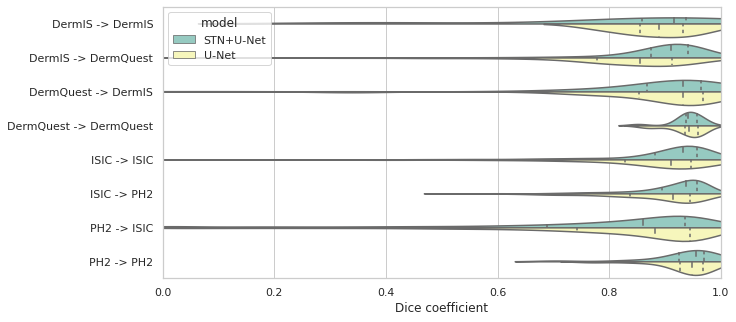

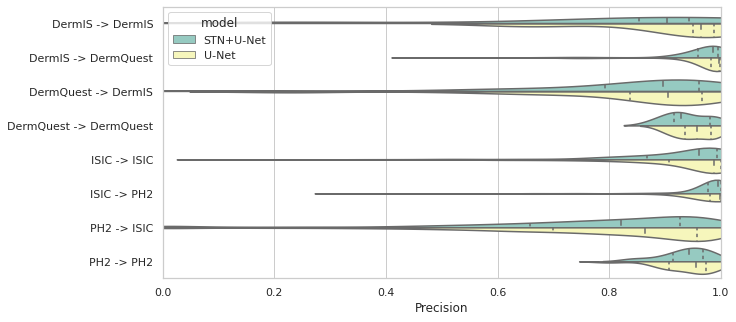

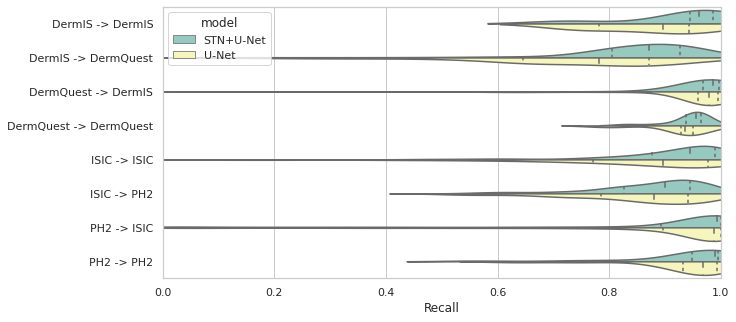

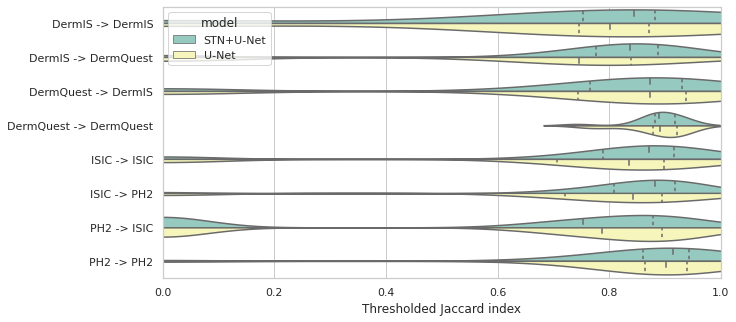

In [102]:
for metric, title in metrics:
  box_plot_metric(metric, title)
  plt.show()